The bankruptcy of a company frequently has severe consequences for many parties. Employees lose their jobs, companies that were doing business with them lose their business, creditors that invested likely won’t recoup their losses, customers will have to find an alternative. If bankruptcies happen across many companies simultaneously, unemployment rises, social safety nets are strained, and communities lose out on tax dollars and goods and services. (Segal)

The motivation for studying business bankruptcy is its significant impact on the economy and society. Predicting bankruptcy helps investors and creditors minimize losses, allows policymakers to support struggling businesses, and preserves jobs and local economies. By identifying at-risk companies early, we can take action to protect stakeholders and maintain financial stability.

The approach uses Logistic Regression, Random Forest Classifier, and Extreme Gradient Boosting to predict business bankruptcy. The data is preprocessed by handling missing values and normalizing features. Logistic regression serves as a simple, interpretable baseline model, while random forest captures complex patterns and interactions. Extreme Gradient Boosting goes a step above both for capturing relations. The models are fine-tuned for better performance. Evaluation is based on metrics like ROC-AUC and a confusion matrix.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from ucimlrepo import fetch_ucirepo 
from xgboost import XGBClassifier

# Fetch the dataset
bankruptcies_data = fetch_ucirepo(id=365)
X = pd.DataFrame(bankruptcies_data.data.features, columns=bankruptcies_data.data.feature_names)
y = bankruptcies_data.data.targets 



The dataset used is 5 years’ worth of detailed financial analytics from 10k+ Polish companies (Tomczak). Companies are classified as bankrupt or not bankrupt over that period. To give an idea of the style of data collected, the first 10 out of 64 features are:
1.	 net profit / total assets
2.	total liabilities / total assets
3.	working capital / total assets
4.	current assets / short-term liabilities
5.	[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
6.	retained earnings / total assets
7.	EBIT / total assets
8.	book value of equity / total liabilities
9.	sales / total assets
10.	equity / total assets
\
In the code below, the shape, head, and summary of the data is printed. 

In [15]:
print("Dataset Shape:", X.shape)
print("\nSample Data:\n", X.head())
print("\nData Summary:\n", X.describe())

Dataset Shape: (43405, 65)

Sample Data:
    year        A1       A2       A3      A4       A5       A6        A7  \
0     1  0.200550  0.37951  0.39641  2.0472  32.3510  0.38825  0.249760   
1     1  0.209120  0.49988  0.47225  1.9447  14.7860  0.00000  0.258340   
2     1  0.248660  0.69592  0.26713  1.5548  -1.1523  0.00000  0.309060   
3     1  0.081483  0.30734  0.45879  2.4928  51.9520  0.14988  0.092704   
4     1  0.187320  0.61323  0.22960  1.4063  -7.3128  0.18732  0.187320   

        A8      A9  ...       A55       A56      A57      A58       A59  \
0  1.33050  1.1389  ...  348690.0  0.121960  0.39718  0.87804  0.001924   
1  0.99601  1.6996  ...    2304.6  0.121300  0.42002  0.85300  0.000000   
2  0.43695  1.3090  ...    6332.7  0.241140  0.81774  0.76599  0.694840   
3  1.86610  1.0571  ...   20545.0  0.054015  0.14207  0.94598  0.000000   
4  0.63070  1.1559  ...    3186.6  0.134850  0.48431  0.86515  0.124440   

      A60     A61      A62     A63      A64  
0  8.4160 

array([[<Axes: title={'center': 'year'}>, <Axes: title={'center': 'A1'}>,
        <Axes: title={'center': 'A2'}>, <Axes: title={'center': 'A3'}>,
        <Axes: title={'center': 'A4'}>, <Axes: title={'center': 'A5'}>,
        <Axes: title={'center': 'A6'}>, <Axes: title={'center': 'A7'}>],
       [<Axes: title={'center': 'A8'}>, <Axes: title={'center': 'A9'}>,
        <Axes: title={'center': 'A10'}>, <Axes: title={'center': 'A11'}>,
        <Axes: title={'center': 'A12'}>, <Axes: title={'center': 'A13'}>,
        <Axes: title={'center': 'A14'}>, <Axes: title={'center': 'A15'}>],
       [<Axes: title={'center': 'A16'}>, <Axes: title={'center': 'A17'}>,
        <Axes: title={'center': 'A18'}>, <Axes: title={'center': 'A19'}>,
        <Axes: title={'center': 'A20'}>, <Axes: title={'center': 'A21'}>,
        <Axes: title={'center': 'A22'}>, <Axes: title={'center': 'A23'}>],
       [<Axes: title={'center': 'A24'}>, <Axes: title={'center': 'A25'}>,
        <Axes: title={'center': 'A26'}>, <A

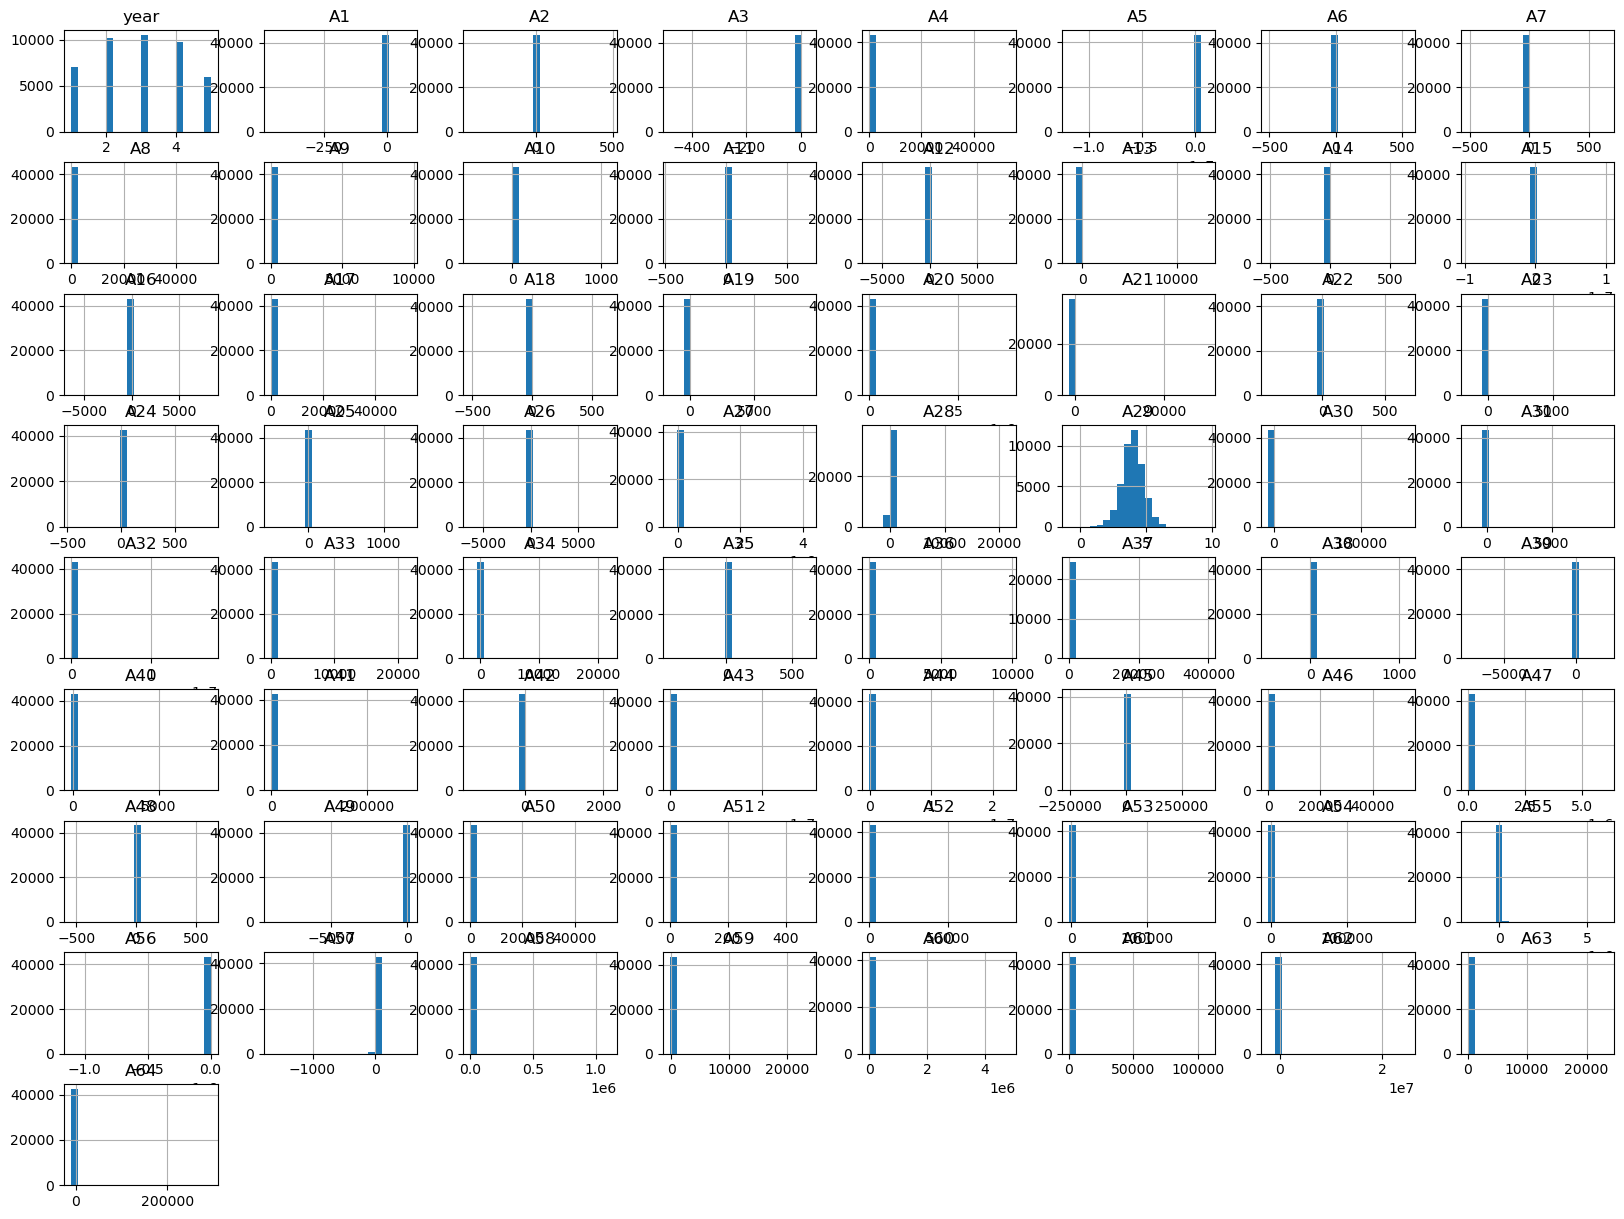

In [16]:
X.hist(bins=20, figsize=(20, 15))


The features usually fall within close margins of each other but also include severe outliers, so the data will be filtered to keep an appropriate scale for better visualization.

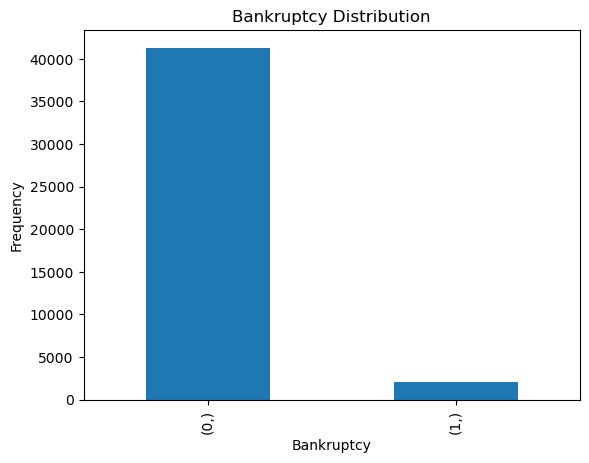

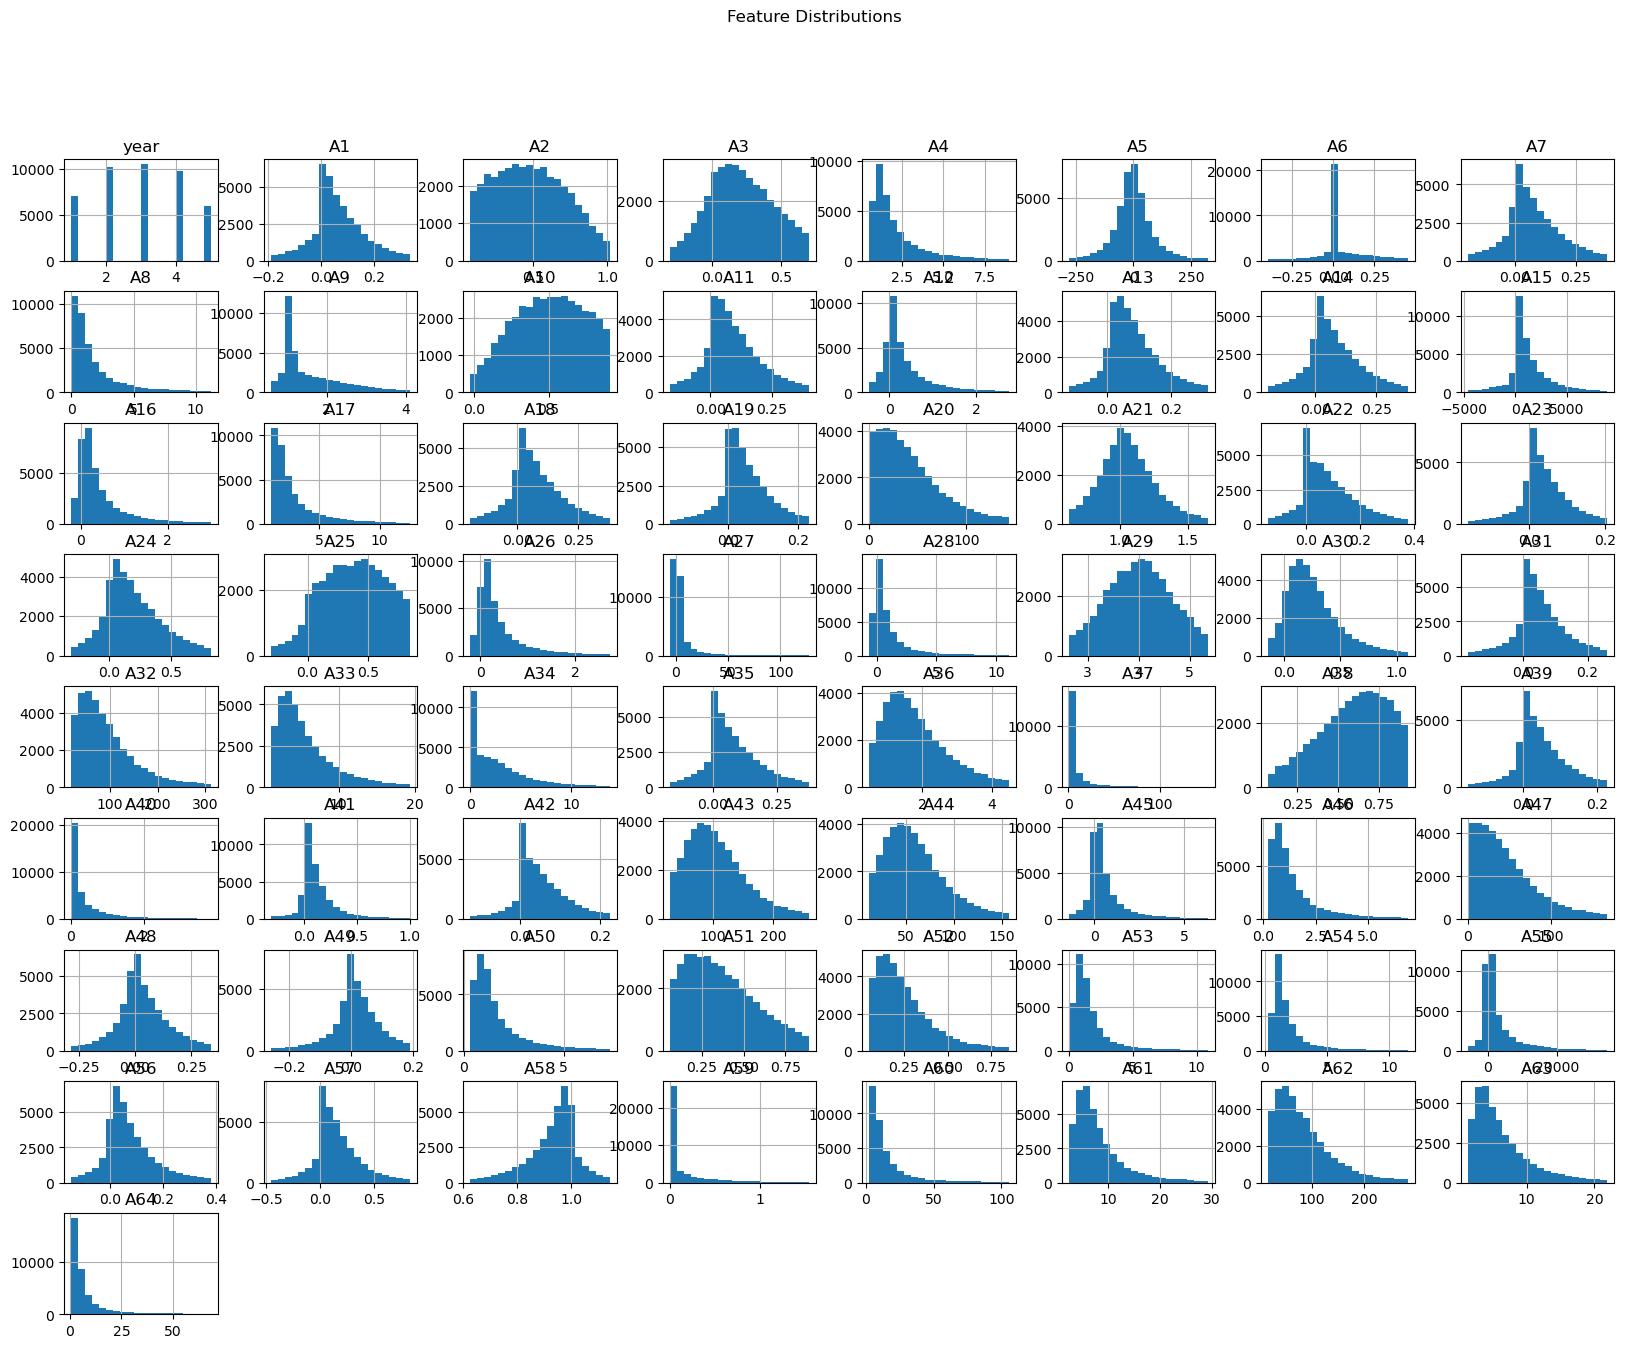

In [17]:
# Visualize target distribution
y.value_counts().plot(kind='bar')
plt.title("Bankruptcy Distribution")
plt.xlabel("Bankruptcy")
plt.ylabel("Frequency")
plt.show()

# Additional visualizations
# Histogram for features
X_filtered = X[(X >= X.quantile(0.05)) & (X <= X.quantile(0.95))]
X_filtered.hist(bins=20, figsize=(20, 15))
plt.suptitle("Feature Distributions")
plt.show()

Here's a correlation heatmap showing which features are correlated.

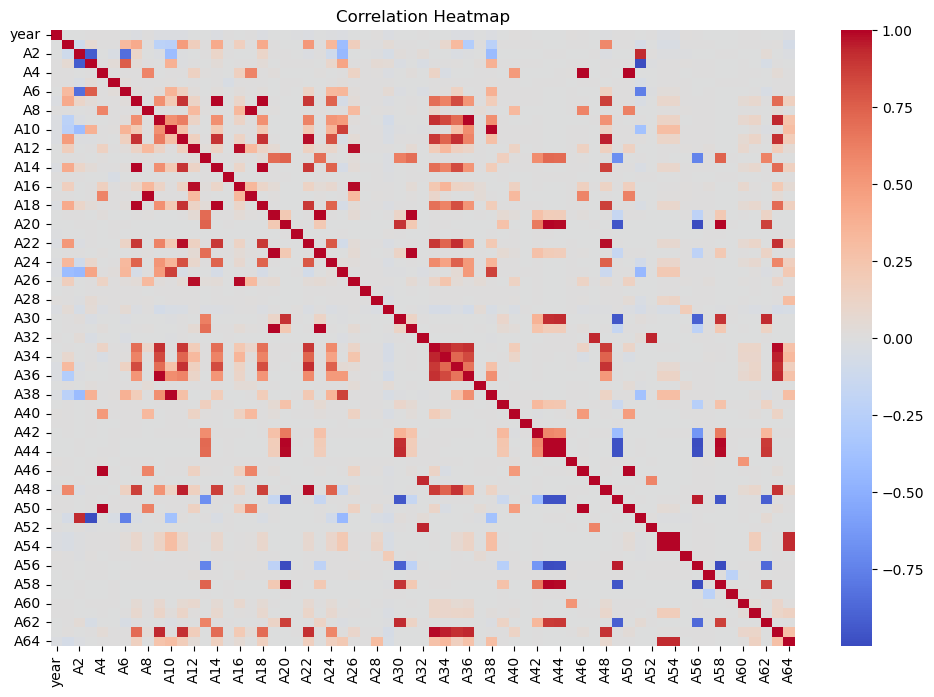

In [18]:
correlation_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

There are some missing values, in the interest of preserving the size of the dataset for a better result, the data will be imputed using the mean. The imputed values will be used for the first two models.

In [19]:
# Check for missing values
print("\nMissing Values:\n", X.isnull().sum())


# Perform basic (visual) analysis
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


Missing Values:
 year       0
A1         8
A2         8
A3         8
A4       134
        ... 
A60     2152
A61      102
A62      127
A63      134
A64      812
Length: 65, dtype: int64


After imputing, data will be split and standardized.

In [20]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The first algorithm used is Logistic Regression. Logistic Regression is a statistical method used for binary classification.  It predicts the probability of a sample belonging to one of two classes based on its features. The predicted probability is fed into a sigmoid function to collapse the prediction to a number between 0 and 1. The advantage of Logistic Regression is its simplicity. (Schoonjans)


Logistic Regression Performance:

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      8263
           1       0.29      0.00      0.01       418

    accuracy                           0.95      8681
   macro avg       0.62      0.50      0.49      8681
weighted avg       0.92      0.95      0.93      8681



<Axes: >

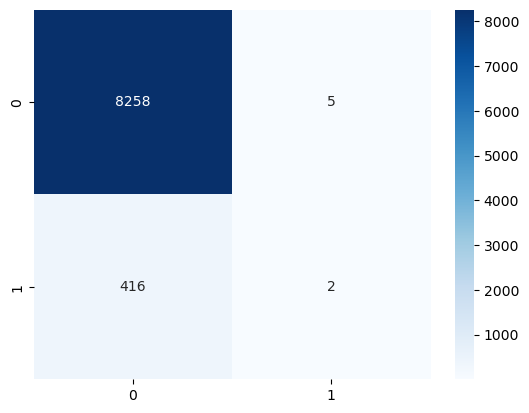

In [21]:
# Model 1: Logistic Regression
logistic_model = LogisticRegression(random_state=42, max_iter=500)
logistic_model.fit(X_train, y_train.values.ravel())
y_pred_logistic = logistic_model.predict(X_test)
y_proba_logistic = logistic_model.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Performance:\n")
print(classification_report(y_test, y_pred_logistic))

sns.heatmap(confusion_matrix(y_test, y_pred_logistic), annot=True, fmt="d", cmap="Blues")

Logistic Regression predicted the "not bankruptcy class" (0) well, as shown by a f1 score of 0.98. Logistic Regression utterly failed to accurately predict the bankruptcy class (1), with a f1 score of 0.01. 2 out of 418 bankruptcies were predicted. These results are not usable at all. Let’s move to a better model.

The second model used is a Random Forest Classifier (RFC). The RFC model is much more complex than Logistic Regression. RFC operates by making decision trees during the training phase and combining their outputs to improve accuracy. RFC also introduces randomness to reduce overfitting by training each tree on a random subset of the data and considering a random subset of features at each split. When processing the final classification for a sample, the prediction is based on the majority of the results from all decision trees. RFC shows strong performance with large datasets and high-dimensional spaces but can be computationally intensive and less interpretable than simpler models. (Banerjee)


Random Forest Performance:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8263
           1       0.88      0.33      0.49       418

    accuracy                           0.97      8681
   macro avg       0.92      0.67      0.73      8681
weighted avg       0.96      0.97      0.96      8681



<Axes: >

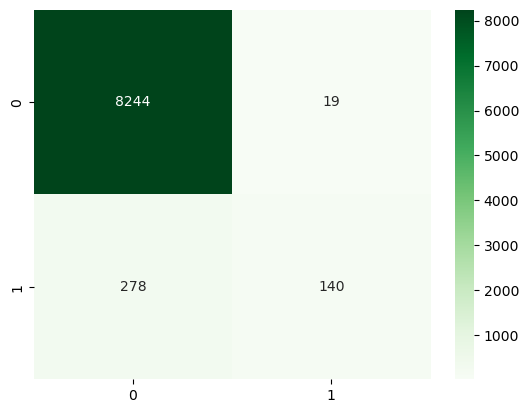

In [22]:
# Model 2: Random Forest Classifier
XGB = RandomForestClassifier(random_state=42, n_estimators=100)
XGB.fit(X_train, y_train.values.ravel())
y_pred_rf = XGB.predict(X_test)
y_proba_rf = XGB.predict_proba(X_test)[:, 1]

print("\nRandom Forest Performance:\n")
print(classification_report(y_test, y_pred_rf))

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens")

With f1 scores of 0.98 and 0.49, this model did a significantly better job of classification than Logistic Regression, but there is still improvement to be made. RFC predicted 140 out of 418 bankruptcies in the testing set. Interestingly, while there was a massive boost in identifying bankruptcies, there was also a minor increase in predicting non-bankruptcies as bankruptcies, from 4 out of 8263 cases in Logistic Regression to 19 out of 8263 cases in RFC.

The third model is Extreme Gradient Boosting (XGB). XGB works by building models sequentially, where each model attempts to correct the errors of the previous ones. It incorporates techniques like L1 and L2 regularization to prevent overfitting, tree pruning for optimal splits, and parallel processing for faster computations. It handles missing values automatically. XGB is widely used in predictive modeling competitions and practical applications like customer segmentation, churn prediction, and fraud detection. Its ability to process large datasets and handle missing data effectively makes it a top choice for many machine learning tasks. (Mesut)

Because XGB handles missing values on its own, the data will first be reprocessed, using the same paramaters, but this time without imputing.

In [23]:
X = pd.DataFrame(bankruptcies_data.data.features, columns=bankruptcies_data.data.feature_names)
y = bankruptcies_data.data.targets 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Extreme Gradient Boosting Performance:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8263
           1       0.95      0.60      0.73       418

    accuracy                           0.98      8681
   macro avg       0.96      0.80      0.86      8681
weighted avg       0.98      0.98      0.98      8681



<Axes: >

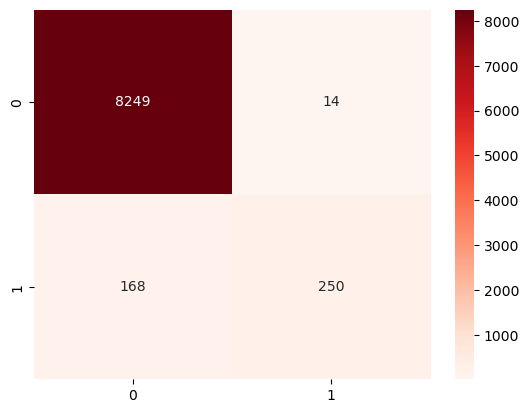

In [24]:
# Model 3: Extreme Gradient Boosting
XGB = XGBClassifier()
XGB.fit(X_train, y_train.values.ravel())
y_pred_xgb = XGB.predict(X_test)
y_proba_xgb = XGB.predict_proba(X_test)[:, 1]

print("\nExtreme Gradient Boosting Performance:\n")
print(classification_report(y_test, y_pred_xgb))

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Reds")

With f1 scores of 0.99 and 0.73, XGB shows improvements over the previous two models. XGB predicted 250 out of 418 bankruptcies in the testing set. There was also a decrease in false positives from RFC, from 19 to 14. This model shows the best performance so far. 

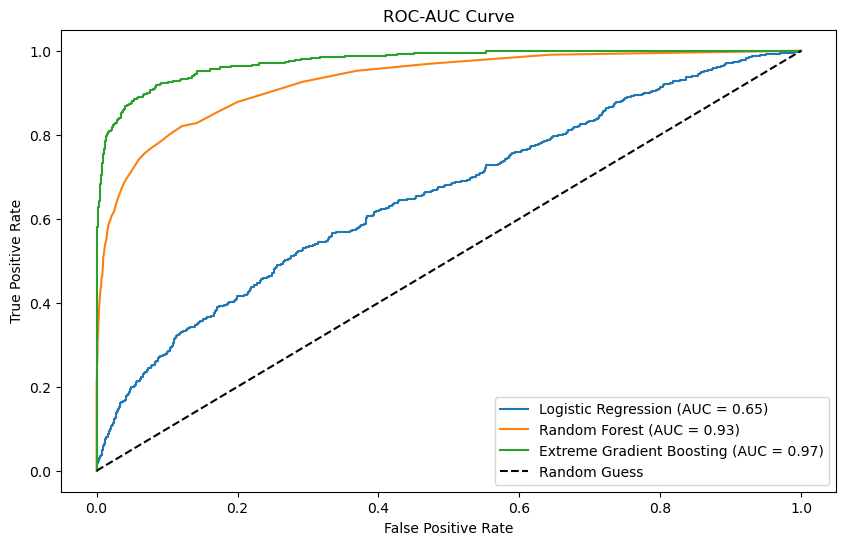

In [25]:

# ROC-AUC Curves
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_proba_logistic)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_logistic = auc(fpr_logistic, tpr_logistic)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f"Logistic Regression (AUC = {auc_logistic:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"Extreme Gradient Boosting (AUC = {auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



The ROC-AUC curve helps show the difference in performance between models. All models did better than random guess, RFC and XGB did significantly better than Logistic Regression, and XGB did the best overall. 

Conclusion:
This project was a great experience for solidifying what I learned in this class and using it for something that I was interested in. I learned how to find a dataset, analyze its quality, process it, visualize it, feed it into a model, and analyze the results. I wanted to get good model results so I was challenged with finding a model that would perform well. XGB ended up being the best model I could find. Understanding the dataset was also a challenge, it took me a lot of time looking at analytics of the data to understand the severity of the outliers. I had a much easier time visualizing the data after filtering out outliers, as seen in the graphs of the features.

Citations:

Segal, Troy. “Corporate Bankruptcy: How It Works, What It Means for Investors.” Investopedia, Investopedia, www.investopedia.com/articles/01/120501.asp. Accessed 11 Dec. 2024. 

Tomczak, Sebastian. "Polish Companies Bankruptcy." UCI Machine Learning Repository, 2016, https://doi.org/10.24432/C5F600.

Schoonjans, Frank. “Logistic Regression.” MedCalc, MedCalc Software, 2 Sept. 2024, www.medcalc.org/manual/logistic-regression.php. 

Banerjee, Prashant. “Random Forest Classifier Tutorial.” Kaggle, Kaggle, 13 Mar. 2020, www.kaggle.com/code/prashant111/random-forest-classifier-tutorial. 

Mesut, Burcu. “Extreme Gradient Boosting.” Extreme Gradient Boosting - an Overview | ScienceDirect Topics, www.sciencedirect.com/topics/computer-science/extreme-gradient-boosting. Accessed 11 Dec. 2024. 

Acknowledgement:

AI was used for correcting logical and syntactical errors in code.